<a href="https://colab.research.google.com/github/gcalanch/DMA-Caras/blob/main/clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Carga librerias

In [14]:
import polars as pl
import numpy as np
import pickle
import os
import joblib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
import os
from sklearn.manifold import Isomap
from PIL import Image


# Clase Multiperceptron

In [15]:
# definicion de las funciones de activacion
# y sus derivadas agregando las versiones VECTORIZADAS
def func_eval(fname, x):
    if fname == "purelin":
        return x
    elif fname == "logsig":
        return 1.0 / (1.0 + np.exp(-x))
    elif fname == "tansig":
        return 2.0 / (1.0 + np.exp(-2.0 * x)) - 1.0
    else:
        raise ValueError(f"Función de activación no soportada: {fname}")

# version vectorizada de func_eval
func_eval_vec = np.vectorize(func_eval)

def deriv_eval(fname, y):
    if fname == "purelin":
        return 1.0
    elif fname == "logsig":
        return y * (1.0 - y)
    elif fname == "tansig":
        return 1.0 - y * y

# version vectorizada de deriv_eval
deriv_eval_vec = np.vectorize(deriv_eval)

# Definicion de la clase de multiperceptron (red neuronal con múltiples capas ocultas)

class multiperceptron(object):
    """Multiperceptron class"""

    def _red_init(self, semilla) -> None:

        niveles = self.red['arq']['layers_qty']
        np.random.seed(semilla)

        for i in range(niveles):
           nivel = dict()
           nivel['id'] = i
           nivel['last'] = (i==(niveles-1))
           nivel['size'] = self.red["arq"]["layers_size"][i]
           nivel['func'] = self.red["arq"]["layers_func"][i]

           # Se determina cuántas entradas recibe la capa actual
           if( i==0 ):
              entrada_size = self.red['arq']['input_size']
           else:
              entrada_size =  self.red['arq']['layers_size'][i-1]

           salida_size =  nivel['size']

           # los pesos, inicializados random
           nivel['W'] = np.random.uniform(-0.5, 0.5, [salida_size, entrada_size])
           nivel['w0'] = np.random.uniform(-0.5, 0.5, [salida_size, 1])

           # los momentos, inicializados en CERO
           nivel['W_m'] = np.zeros([salida_size, entrada_size])
           nivel['w0_m'] = np.zeros([salida_size, 1])

           self.red['layer'].append(nivel)

    # constructor generico
    def __init__(self) -> None:
        self.data = dict()
        self.red = dict()
        self.carpeta = ""

    # inicializacion full
    def inicializar(self, df, campos, clase, hidden_layers_sizes, layers_func,
                 semilla, carpeta) -> None:

        # Procesamiento de los datos de entrada (features)
        self.data['X'] = np.array(df.select(campos))
        # Normalización (escalado) de los datos para que los atributos tengan media 0 y desviación estándar 1
        X_mean = self.data['X'].mean(axis=0)
        X_sd = self.data['X'].std(axis=0)
        self.data['X'] = (self.data['X'] - X_mean)/X_sd

        #  Procesamiento de etiquetas Ylabel en  numpy
        label =df.select(clase)
        self.data['Ylabel'] = np.array(label).reshape(len(label))

        # one-hot-encoding de Y . Realiza la codificacion "one hot" de las etiquetas (Convierte cada categoría única en una columna binaria separada y representa la presencia con 1 y la ausencia con 0.)
        col_originales = df.columns
        self.data['Y'] = np.array( df.to_dummies(clase).drop(col_originales, strict=False) )
        col_dummies = sorted( list( set(df.to_dummies(clase).columns) -  set(col_originales)))
        # Need to import reduce from functools
        from functools import reduce
        clases_originales = reduce(lambda acc, x: acc + [x[(len(clase)+1):]], col_dummies, [])


        # Construcción de la arquitectura de la red
        tamanos = hidden_layers_sizes
        tamanos.append(self.data['Y'].shape[1])

        arquitectura = {
             'input_size' : self.data['X'].shape[1],
             'input_mean' : X_mean,
             'input_sd' :  X_sd,
             'output_values' : clases_originales,
             'layers_qty' : len(hidden_layers_sizes),
             'layers_size' : tamanos ,
             'layers_func' : layers_func,
        }

        self.red['arq'] = arquitectura

        # inicializo  work . Inicialización de información de entrenamiento
        self.red['work'] = dict()
        self.red['work']['epoch'] = 0
        self.red['work']['MSE'] = float('inf')
        self.red['work']['train_error_rate'] = float('inf')

        # Preparación de las capas y pesos
        self.red['layer'] = list()
        self._red_init(semilla)

        # grabo el entorno. Guardar el entorno en disco
        self.carpeta = carpeta
        os.makedirs(self.carpeta, exist_ok=True)
        with open(self.carpeta+"/data.pkl", 'wb') as f:
            pickle.dump(self.data, f)

        with open(self.carpeta+"/red.pkl", 'wb') as f:
            pickle.dump(self.red, f)


    # predigo a partir de modelo recien entrenado
    def  predecir(self, df_new, campos, clase) -> None:


        niveles = self.red['arq']['layers_qty']

        # etapa forward
        # recorro hacia adelante, nivel a nivel
        X_new =  np.array( df_new.select(campos))


        # estandarizo manualmente con las medias y desvios que almacene durante el entrenamiento
        X_new = (X_new - self.red['arq']['input_mean'])/self.red['arq']['input_sd']


        # la entrada a la red,  el X que es TODO  x_new
        entrada = X_new.T

        for i in range(niveles):
          estimulos = self.red['layer'][i]['W'] @ entrada + self.red['layer'][i]['w0']
          salida =  func_eval_vec(self.red['layer'][i]['func'], estimulos)
          entrada = salida  # para la proxima vuelta

        # me quedo con la neurona de la ultima capa que se activio con mayor intensidad
        pred_idx = np.argmax( salida.T, axis=1)
        pred_raw = np.max( salida.T, axis=1)
        # Inicializamos out y error_rate a None
        out=None
        new_error_rate = None

        if clase: # Verificamos si la variable clase tiene un valor (no es cadena vacía o None)
            out = np.array(self.red['arq']['output_values'])

            true_labels = np.array(df_new.select(clase)).flatten() # Aseguramos que sea un array plano

            predicted_labels = out[pred_idx] # Estos serán strings (nombres de clase)
            new_error_rate = np.mean(true_labels != predicted_labels)

        # Modify the return statement to handle the case where 'out' is None
        # If 'out' is None, we return the raw indices instead of trying to use 'out'
        # If 'out' is not None, we return the predicted class names based on the indices
        if out is not None:
            return (out[pred_idx], pred_raw, new_error_rate)
        else:
            # When 'clase' is not provided, we cannot return class names, so we return
            # the indices of the activated neurons instead of trying to access 'out'
            # We also return None for new_error_rate as true labels are not available
            return (pred_idx, pred_raw, new_error_rate)


    # cargo un modelo ya entrenado, grabado en carpeta

#    def cargar_modelo(self, carpeta) -> None:
#        self.carpeta = carpeta

#        with open(self.carpeta+"/red.pkl", 'rb') as f:
#          self.red = pickle.load(f)

#        return (self.red['work']['epoch'],
#                self.red['work']['MSE'],
#                self.red['work']['train_error_rate'] )


    def cargar_modelo(self, fuente) -> None:
        """
        Carga la red desde una carpeta local o una URL GitHub.
        Si `fuente` comienza con 'http', descarga usando requests.
        """
        if fuente.startswith('http'):
            # Descarga red.pkl
            resp = requests.get(fuente + "/red.pkl")
            resp.raise_for_status()
            self.red = pickle.loads(resp.content)

            # Descarga data.pkl (opcional, si la usas)
            resp2 = requests.get(fuente + "/data.pkl")
            resp2.raise_for_status()
            self.data = pickle.loads(resp2.content)
        else:
            # Origen local
            with open(fuente + "/red.pkl", 'rb') as f:
                self.red = pickle.load(f)
            with open(fuente + "/data.pkl", 'rb') as f:
                self.data = pickle.load(f)

        # Devuelve información de entrenamiento si está disponible
        return (
            self.red['work']['epoch'],
            self.red['work']['MSE'],
            self.red['work']['train_error_rate']
        )


file_id = "1Rli0nTobgLrgyGZXD5Ygvrb59kK6sMKW"
destino = "/content/modelo_isomap.pkl"

# Descargar desde Drive
import gdown
url = f"https://drive.google.com/uc?id={file_id}"
if not os.path.exists(destino):
    print("Descargando modelo Isomap desde Drive…")
    gdown.download(url, destino, quiet=False)
else:
    print("El modelo ya existe en:", destino)

# Verificar carga
import joblib
try:
    isomap = joblib.load(destino)
    print("✅ Modelo Isomap cargado correctamente.")
except Exception as e:
    print("❌ Error cargando Isomap:", e)

Descargando modelo Isomap desde Drive…


Downloading...
From (original): https://drive.google.com/uc?id=1Rli0nTobgLrgyGZXD5Ygvrb59kK6sMKW
From (redirected): https://drive.google.com/uc?id=1Rli0nTobgLrgyGZXD5Ygvrb59kK6sMKW&confirm=t&uuid=1f9d7d2e-2b3b-45e6-91a8-6ae9f000b5dd
To: /content/modelo_isomap.pkl
100%|██████████| 212M/212M [00:04<00:00, 50.0MB/s]


✅ Modelo Isomap cargado correctamente.


# Directorios y campos de entrada

In [20]:
# URLs raw de GitHub
github_base = "https://raw.githubusercontent.com/AgomferAustral/DMA-Caras/main/caras/prod"
url_red  = f"{github_base}/red.pkl"
url_data = f"{github_base}/data.pkl"

ruta_isomap = "/content/modelo_isomap.pkl"


modelo_path = "/content/drive/MyDrive/DMA/prod"
datos_path = "/content/drive/MyDrive/DMA/prod"
imagenes_path ="/content/drive/MyDrive/Detectadasprod21"
salida_path = "/content/drive/MyDrive/caras/prod/resultados.csv"
fotos = "/content/drive/MyDrive/Detectadasprod21"

campos = [f"PC{i}" for i in range(1, 51)]

# Ejecucion

Carga de datos

In [7]:
# Identificar archivos de imagenes sin etiquetas
def leer_imagenes(i_path):
    """
    Identifica archivos de imagen en una carpeta que no están en subcarpetas (consideradas "etiquetas").
    Args:
        i_path (str): La ruta a la carpeta principal donde buscar imágenes.
    Returns:
        list: Una lista de rutas a archivos de imagen que no se encuentran en ninguna subcarpeta.
    """
    imagenes = []
    if not os.path.isdir(i_path):
        print(f"La ruta '{i_path}' no es un directorio válido.")
        return imagenes

    for item in os.listdir(i_path):
        item_path = os.path.join(i_path, item)
        if os.path.isfile(item_path) and item.lower().endswith(('.png', '.jpg', '.jpeg')):
            imagenes.append(item_path)

    return imagenes

print(f"Buscando imágenes sin etiqueta en: {imagenes_path}")
imagenes = leer_imagenes(imagenes_path)

if imagenes:
    print(f"Se encontraron {len(imagenes)} imágenes sin etiqueta:")
else:
    print("No se encontraron imágenes sin etiqueta en el directorio especificado.")


Buscando imágenes sin etiqueta en: /content/drive/MyDrive/Detectadasprod21
Se encontraron 17 imágenes sin etiqueta:


Carga Modelo ISOMAP

In [17]:
# Verifica si el archivo existe antes de intentar cargarlo
if os.path.exists(ruta_isomap):
  print(f"Cargando modelo Isomap desde: {ruta_isomap}")
  try:
    # Verificar el tamaño del archivo (opcional, pero útil para diagnóstico)
    file_size = os.path.getsize(ruta_isomap)
    if file_size == 0:
        print(f"Advertencia: El archivo del modelo Isomap en {ruta_isomap} está vacío.")
    else:
        print(f"Tamaño del archivo Isomap: {file_size} bytes.")

    isomap = joblib.load(ruta_isomap)
    print("Modelo Isomap cargado exitosamente usando joblib.")

  except FileNotFoundError:
      print(f"Error: El archivo del modelo Isomap en {ruta_isomap} no se encontró.")
  except Exception as e:
      # Capturar cualquier otro error (incluyendo posibles problemas de formato si joblib falla)
      print(f"Ocurrió un error al cargar el modelo Isomap con joblib: {e}")
      print("Asegúrese de que el archivo fue guardado correctamente con joblib.dump().")

else:
  print(f"Advertencia: No se encontró el archivo del modelo Isomap en {ruta_isomap}.")
  print("Asegúrese de que el modelo fue guardado correctamente en un paso anterior.")

Cargando modelo Isomap desde: /content/modelo_isomap.pkl
Tamaño del archivo Isomap: 211795908 bytes.
Modelo Isomap cargado exitosamente usando joblib.


In [21]:
print(f"Buscando imágenes sin etiqueta en: {fotos}")
imagenes_prod = leer_imagenes(fotos)

if imagenes_prod:
    print(f"Se encontraron {len(imagenes_prod)} imágenes sin etiqueta:")
else:
    print("No se encontraron imágenes sin etiqueta en el directorio especificado.")

Buscando imágenes sin etiqueta en: /content/drive/MyDrive/Detectadasprod21
Se encontraron 17 imágenes sin etiqueta:


In [22]:
print("Vectorizando imágenes y aplicando reducción de dimensionalidad con Isomap...")
imagenes_vectorizadas = np.array([np.array(Image.open(img).convert('L')).flatten() for img in imagenes_prod])

Vectorizando imágenes y aplicando reducción de dimensionalidad con Isomap...


In [23]:
# Usa el modelo isomap para transformar los nuevos datos.
imagenes_isomap = isomap.transform(imagenes_vectorizadas)

print(f"Dimensión después de Isomap: {imagenes_isomap.shape}")

Dimensión después de Isomap: (17, 50)


In [24]:
data_dict = {f"PC{i+1}": imagenes_isomap[:, i] for i in range(imagenes_isomap.shape[1])}
# Usar la lista imagenes_prod que corresponde a las imágenes que fueron transformadas por Isomap
data_dict["ruta_imagen"] = imagenes_prod
df_isomap = pl.DataFrame(data_dict)


print("DataFrame creado a partir de Isomap:")
print(df_isomap.head())

DataFrame creado a partir de Isomap:
shape: (5, 51)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ PC1       ┆ PC2       ┆ PC3       ┆ PC4       ┆ … ┆ PC48      ┆ PC49      ┆ PC50      ┆ ruta_ima │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ gen      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ -5970.434 ┆ -4158.442 ┆ -3784.122 ┆ -502.8600 ┆ … ┆ -1070.613 ┆ -1128.250 ┆ 1123.6955 ┆ /content │
│ 293       ┆ 173       ┆ 531       ┆ 58        ┆   ┆ 643       ┆ 662       ┆ 21        ┆ /drive/M │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ yDrive/D │
│           ┆           ┆           ┆  

Carga modelo etrenado

In [25]:
# mp_prod = multiperceptron()
# mp_prod.cargar_modelo(modelo_path)

modelo_url = "https://raw.githubusercontent.com/AgomferAustral/DMA-Caras/main/caras/prod"
mp_prod = multiperceptron()
epoch, mse, error_rate = mp_prod.cargar_modelo(modelo_url)
print(f"Modelo cargado: epoch={epoch}, MSE={mse}, error_rate={error_rate}")

Modelo cargado: epoch=141, MSE=0.0009935644838181643, error_rate=0.008113590263691683


Prediccion

In [26]:
# Predecir (pasamos una columna vacía como clase)

(y_hat, y_raw, new_error_rate)= mp_prod.predecir(df_isomap, campos, clase="")

Visualizacion de las Predicciones

In [28]:
#visualizar las predicciones con el nombre de las etiquetas usadas para entrenamiento

# with open(modelo_path + "/red.pkl", 'rb') as f:# Cargar el archivo red.pkl para obtener los nombres de las etiquetas
#    red_info = pickle.load(f)

red_info = mp_prod.red

clases_originales = red_info['arq']['output_values']# Obtener los nombres de las etiquetas originales

# Crea un nuevo DataFrame Polars con los resultados
df_resultados = df_isomap.with_columns([
    pl.Series(name="etiqueta_predicha", values=[clases_originales[idx] for idx in y_hat]),
    pl.Series(name="intensidad_predicha", values=y_raw)
])

# Guarda el nuevo DataFrame en un archivo CSV
df_resultados.write_csv(salida_path, separator='\t')
print(f"Resultados guardados en: {salida_path}")

# Mostrar el DataFrame de resultados (opcional)
print("\nDataFrame con predicciones y etiquetas:")
print(df_resultados.head())

# Crea una lista de descripciones para cada predicción
descripciones = [f"Muestra {i}" for i in range(len(y_hat))]

# Crea un DataFrame Polars con los resultados formateados
df_prediccion_formateada = pl.DataFrame({
    "Descripción": descripciones,
    "Etiqueta Predicha": [clases_originales[idx] for idx in y_hat],
    "Intensidad Predicha": y_raw
}).with_columns(
    # Redondear la columna "Intensidad Predicha" a 5 decimales
    pl.col("Intensidad Predicha").round(5)
)

# Imprime el DataFrame
print("\nResultados de la predicción en formato tabla:")
df_prediccion_formateada



Resultados guardados en: /content/drive/MyDrive/caras/prod/resultados.csv

DataFrame con predicciones y etiquetas:
shape: (5, 53)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ PC1       ┆ PC2       ┆ PC3       ┆ PC4       ┆ … ┆ PC50      ┆ ruta_imag ┆ etiqueta_ ┆ intensid │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ en        ┆ predicha  ┆ ad_predi │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ ---       ┆ ---       ┆ cha      │
│           ┆           ┆           ┆           ┆   ┆           ┆ str       ┆ str       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ -5970.434 ┆ -4158.442 ┆ -3784.122 ┆ -502.8600 ┆ … ┆ 1123.6955 ┆ /content/ ┆ Jorgelina ┆ 0.322722 │
│ 293       ┆ 173       ┆ 531       ┆ 58        ┆   ┆ 21      

Descripción,Etiqueta Predicha,Intensidad Predicha
str,str,f64
"""Muestra 0""","""Jorgelina""",0.32272
"""Muestra 1""","""Gabriel""",0.35522
"""Muestra 2""","""Guadalupe""",0.96962
"""Muestra 3""","""Guadalupe""",0.99554
"""Muestra 4""","""Natalia""",0.83325
…,…,…
"""Muestra 12""","""Noelia R""",0.99281
"""Muestra 13""","""Noelia R""",0.55383
"""Muestra 14""","""Guadalupe""",0.17769


#  Definicion de umbral de reconocimiento (Deteccion de Itrusos)


Registros sin identificar (intensidad < 0.5):
shape: (4, 53)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ PC1       ┆ PC2       ┆ PC3       ┆ PC4       ┆ … ┆ PC50      ┆ ruta_imag ┆ etiqueta_ ┆ intensid │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ en        ┆ predicha  ┆ ad_predi │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ ---       ┆ ---       ┆ cha      │
│           ┆           ┆           ┆           ┆   ┆           ┆ str       ┆ str       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ -5970.434 ┆ -4158.442 ┆ -3784.122 ┆ -502.8600 ┆ … ┆ 1123.6955 ┆ /content/ ┆ Jorgelina ┆ 0.322722 │
│ 293       ┆ 173       ┆ 531       ┆ 58        ┆   ┆ 21        ┆ drive/MyD ┆           ┆          │
│           ┆           ┆    

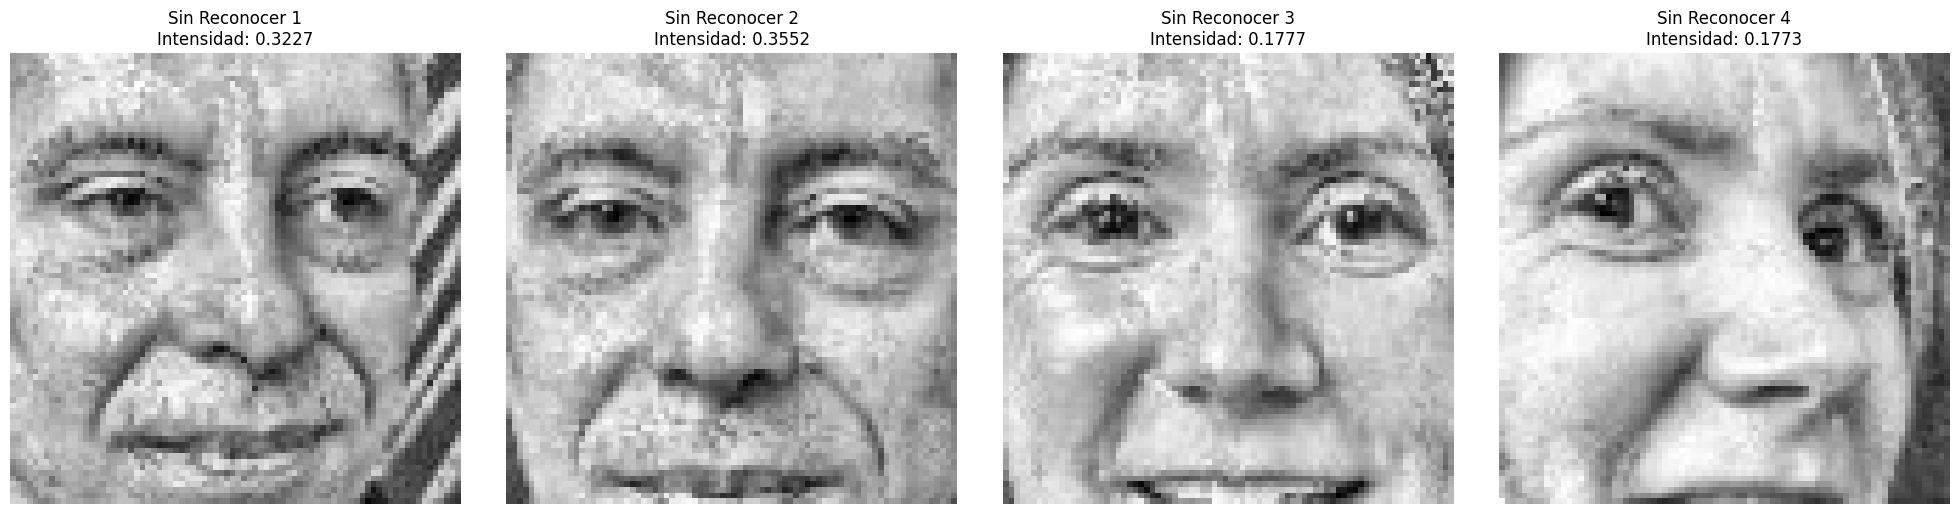

In [29]:
# Filtrar las predicciones basándose en el umbral de confianza y asignar
umbral_confianza = 0.5 # Umbral de confianza


df_sin_reconocer = df_resultados.filter(pl.col("intensidad_predicha") < umbral_confianza)

# Mostrar las filas que corresponden a sin reconocer
print(f"\nRegistros sin identificar (intensidad < {umbral_confianza}):")
if df_sin_reconocer.height > 0:
    print(df_sin_reconocer)
else:
    print("Se identificaron todos los registros dentro del umbral especificado.")

# Mostrar o procesar las imágenes no identificadas

if not df_sin_reconocer.is_empty():
    print("\nVisualizando las primeras 5 imágenes sin reconocer:")
    sin_reconocer_paths = df_sin_reconocer.select("ruta_imagen").to_numpy().flatten()

    # We no longer need the original indices from the 'imagenes' list.
    # We can directly iterate over the paths in sin_reconocer_paths.

    # Visualizar las primeras 5 imágenes directly from sin_reconocer_paths
    num_to_show = min(5, len(sin_reconocer_paths))
    fig, axes = plt.subplots(1, num_to_show, figsize=(20, 5))

    if num_to_show == 1:
        axes = [axes] # Ensure axes is an array even for a single image
    elif num_to_show == 0: # Handle the case where there are no images to show
        print("No images to show below the threshold.")
        plt.close(fig) # Close the figure if no images are displayed
        pass # Skip the rest of the loop if no images
    else:
        # Flatten the axes array for easy iteration if there's more than one subplot
        axes = axes.flatten()


    for i in range(num_to_show):
        img_path = sin_reconocer_paths[i] # Use the path directly from the filtered list
        # To get the intensity for this specific image, we need to look it up in df_sin_reconocer
        current_sin_reconocer_row = df_sin_reconocer.filter(pl.col("ruta_imagen") == img_path)
        if current_sin_reconocer_row.height > 0:
            current_intensity = current_sin_reconocer_row["intensidad_predicha"][0]
        else:
            current_intensity = float('nan') # Should not happen if path is from the dataframe

        try:
            img = mpimg.imread(img_path)
            axes[i].imshow(img, cmap='gray') # assuming they are grayscale images
            axes[i].set_title(f"Sin Reconocer {i+1}\nIntensidad: {current_intensity:.4f}")
            axes[i].axis('off')
        except FileNotFoundError:
            axes[i].set_title(f"Error loading\n{os.path.basename(img_path)}")
            axes[i].axis('off')
            print(f"Error loading image for visualization {img_path}: File not found")
        except Exception as e:
            axes[i].set_title(f"Error loading\n{os.path.basename(img_path)}")
            axes[i].axis('off')
            print(f"Error loading image for visualization {img_path}: {e}")

    if num_to_show > 0: # Only show the plot if there were images to display
        plt.tight_layout()
        plt.show()
else:
    print("Sin imagenes sin reconocer dentro del umbral para mostrar.")


# Visualizacion de la imagenes con la prediccion


Cantidad de imágenes sin reconocer (Intensidad < 0.5): 4

Mostrando imágenes reconocidas (Intensidad >= 0.5):


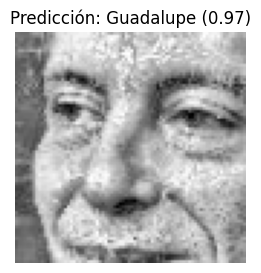

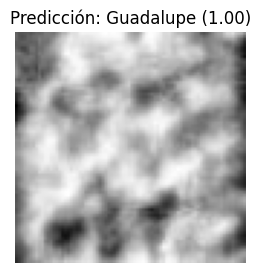

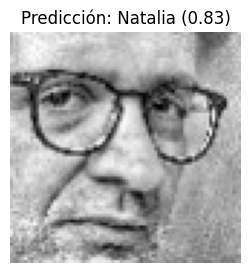

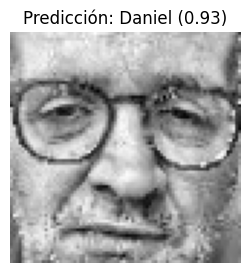

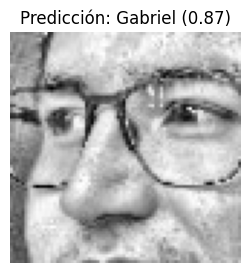

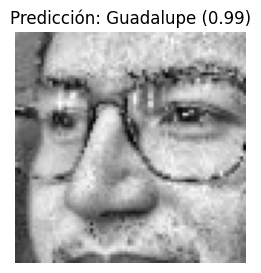

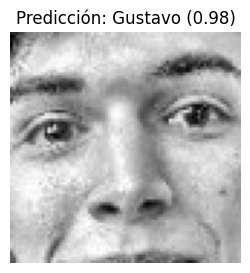

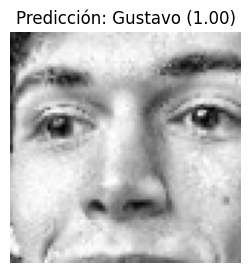

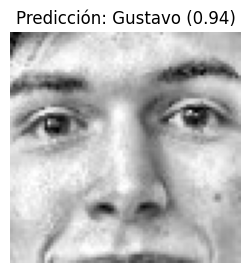

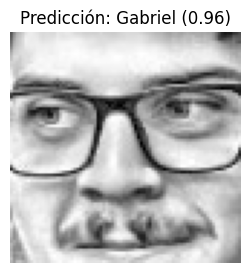

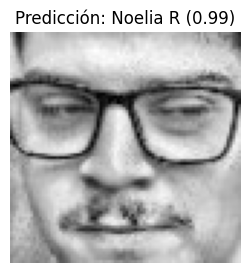

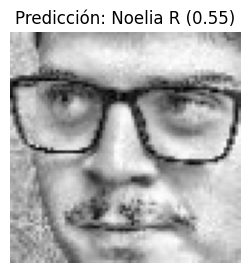

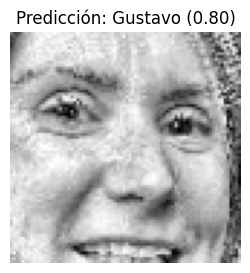

Visualización de imágenes reconocidas completada.

Mostrando imágenes sin reconocer (Intensidad < 0.5):


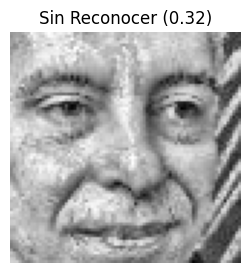

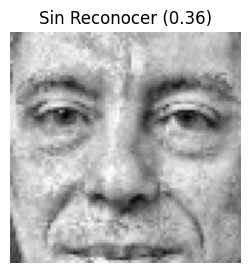

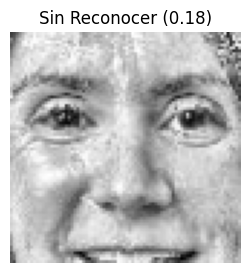

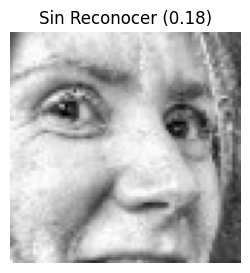

Visualización de imágenes sin reconocer completada.


In [30]:
# Filtra los resultados en base al umbral de confianza para reconomiento
df_reconocidas = df_resultados.filter(pl.col("intensidad_predicha") >= umbral_confianza)

# Cuenta la cantidad de imagenes sin reconocer
num_sin_reconocer = df_sin_reconocer.height

print(f"\nCantidad de imágenes sin reconocer (Intensidad < {umbral_confianza}): {num_sin_reconocer}")

# Visualización de las imágenes reconocidas por encima del umbral
if not df_reconocidas.is_empty():
    print(f"\nMostrando imágenes reconocidas (Intensidad >= {umbral_confianza}):")
    for row in df_reconocidas.iter_rows(named=True):
        ruta_imagen = row["ruta_imagen"]
        prediccion = row["etiqueta_predicha"]
        intensidad = row["intensidad_predicha"]
        try:
            img = mpimg.imread(ruta_imagen)
            plt.figure(figsize=(3, 3))
            plt.imshow(img, cmap='gray') # Usar cmap='gray' si son imágenes en escala de grises
            plt.title(f"Predicción: {prediccion} ({intensidad:.2f})")
            plt.axis('off') # Ocultar ejes
            plt.show()
        except FileNotFoundError:
            print(f"Error: No se encontró la imagen en {ruta_imagen}")
        except Exception as e:
            print(f"Error al mostrar la imagen {ruta_imagen}: {e}")
    print("Visualización de imágenes reconocidas completada.")
else:
    print("No hay imágenes reconocidas por encima del umbral especificado para mostrar.")

# Visualización de las imágenes sin reconocer (las que están en df_sin_reconocer)
if not df_sin_reconocer.is_empty():
    print(f"\nMostrando imágenes sin reconocer (Intensidad < {umbral_confianza}):")
    for row in df_sin_reconocer.iter_rows(named=True):
        ruta_imagen = row["ruta_imagen"]
        intensidad = row["intensidad_predicha"]
        try:
            img = mpimg.imread(ruta_imagen)
            plt.figure(figsize=(3, 3))
            plt.imshow(img, cmap='gray') # Usar cmap='gray' si son imágenes en escala de grises
            plt.title(f"Sin Reconocer ({intensidad:.2f})")
            plt.axis('off') # Ocultar ejes
            plt.show()
        except FileNotFoundError:
            print(f"Error: No se encontró la imagen en {ruta_imagen}")
        except Exception as e:
            print(f"Error al mostrar la imagen {ruta_imagen}: {e}")
    print("Visualización de imágenes sin reconocer completada.")
else:
    print("No hay imágenes sin reconocer por debajo del umbral especificado para mostrar.")
